# Cifar 10 classification performed using Transfer Learning

VGG Net, Alex Net, GoogLeNet, Resnet and Inception v3 trained. 

Accuracy achieved: 

          Models || Test Accuracy 
   
    VGG19_bn Net || 91.06%
  
        Alex Net || 90.05%
      
       GoogLeNet || 95.78%
     
        ResNet34 || 96.42%
      
    Inception v3 || *    
    
*- I was unable to train because of insufficient VRAM. 

# Settings to run on Google Colab

Stores the trained models in Google Drive

Comment the following out if running on your own system

In [65]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [66]:
path = 'gdrive/My Drive/Colab Notebooks/cifar10Project/'
os.listdir(path)

['dataset',
 'CNN_models',
 'DNN_models',
 'dog.png',
 'cifar10TransferLearning2.ipynb',
 '11_truck.png',
 '9993_dog.png',
 '85_dog.png',
 '1387_truck.png',
 'cifar10WebApp.ipynb',
 'cifar10TransferLearning.ipynb',
 'TransferLearning_models_Final',
 'TransferLearning_models',
 'cifar10DNN.ipynb',
 'cifar10CNN.ipynb',
 'cifar10TransferLearningFinal.ipynb',
 'cifar10CNN_Final.ipynb']

# Settings to run on your own system

Comment the following out if running on Google Drive

In [0]:
path = ''

In [0]:
# Sets width of jupyter notebook to full
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Folder Structure

Set up an empty folder called *TransferLearning_models* in your working directory(either on your system or on Google Drive) so that the trained models can be saved and accessed from this folder.

Below code prints folder structure in local device.

In [67]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
            
# currentDirectory = os.getcwd() # For working on own system
currentDirectory = path # For working on Google Colab

list_files(os.path.join(currentDirectory, 'TransferLearning_models'))

TransferLearning_models/
    model8.ckpt
    model11.ckpt
    model12.ckpt
    model17.ckpt
    model28.ckpt
    model33.ckpt
    vggModel.ckpt
    model1.ckpt
    model2.ckpt
    model3.ckpt
    model4.ckpt
    model5.ckpt
    model6.ckpt
    model7.ckpt
    model9.ckpt
    model10.ckpt
    model14.ckpt
    model18.ckpt
    model20.ckpt
    model22.ckpt
    model23.ckpt


# The code to train the models

# 1. Importing Libraries 

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import PIL
import seaborn as sns
import sklearn.metrics
import pickle
import warnings
warnings.filterwarnings("ignore")

## 1.1 PyTorch Version and checking if GPU is active

In [69]:
# Checking if running on GPU or CPU 

# torch.cuda.set_device(1)
x=torch.Tensor(5,3)
print(x.cuda())

tensor([[-1.5088e-38,  0.0000e+00,  4.4842e-44],
        [ 0.0000e+00,         nan,  1.2886e-39],
        [ 2.6964e+23,  2.6823e+23,  1.6782e-07],
        [ 3.2876e+21,  8.1719e+20,  6.8693e-07],
        [ 2.6847e+23,  2.0777e+20,  9.8170e-27]], device='cuda:0')


In [70]:
x.cpu()

tensor([[-1.5088e-38,  0.0000e+00,  4.4842e-44],
        [ 0.0000e+00,         nan,  1.2886e-39],
        [ 2.6964e+23,  2.6823e+23,  1.6782e-07],
        [ 3.2876e+21,  8.1719e+20,  6.8693e-07],
        [ 2.6847e+23,  2.0777e+20,  9.8170e-27]])

In [71]:
print(torch.__version__)

1.1.0


# 2.  Setting up the Cifar 10 Dataset

## 2.1 Data Augmentation

In [0]:
# Set to False if you don't want to augment the data
data_aug = True 

In [0]:
data_aug_transforms = []

if data_aug == True:

    data_aug_transforms = [
        transforms.RandomCrop((32,32), padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15),
#         transforms.RandomAffine(degrees=0, translate=(.3,.7)),
#         transforms.ColorJitter(
#                 brightness=float(0.1*np.random.rand(1)),
#                 contrast=float(0.1*np.random.rand(1)),
#                 saturation=float(0.1*np.random.rand(1)),
#                 hue=float(0.1*np.random.rand(1))),
#         
#         transforms.Resize((224,224)),
        transforms.ColorJitter(hue=.25, saturation=.25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.RandomGrayscale(p=0.1)
                    ]

In [0]:
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ])

## 2.2 Loading the Cifar 10 Dataset using Pytorch

In [0]:
cifar_dataset = torchvision.datasets.CIFAR10(root=path+'dataset/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root=path+'dataset/',
                                          train=False,
                                          transform=test_transform)

# 3. Defining the models

## 3.1 VGG 19 with Batch Normalization model

In [0]:
class VggModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(VggModel, self).__init__()
        
        #load the pretrained model
        vgg11_bn = models.vgg19_bn(pretrained=pretrained)
        self.model = nn.Sequential()
        self.model.features = vgg11_bn.features
        set_parameter_requires_grad(self.model, fine_tune)

        #adding 2 linear layers
        self.model.classifier = nn.Sequential(
                    nn.Linear(in_features= 512, out_features=256, bias=True),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Linear(in_features=256, out_features=n_class, bias=True)
                        )

    def forward(self, x):

        x = self.model.features(x)
        x = x.squeeze()
        out = self.model.classifier(x)

        return out

## 3.2 Interpolation and Alex Net Model

In [0]:
class Interpolate(nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x

In [0]:
class AlexModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(AlexModel, self).__init__()
        
        self.input = Interpolate((227,227),'bilinear')
        #load the pretrained model
        alexNet = models.alexnet(pretrained=pretrained)
        self.model = nn.Sequential()
        self.model.features = alexNet.features
        self.avgpool = alexNet.avgpool
        set_parameter_requires_grad(self.model, fine_tune)

        #adding 3 linear layers
        self.model.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, n_class))
            
            
    def forward(self, x):
        x = self.input(x)
        x = self.model.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        out = self.model.classifier(x)

        return out

## 3.3 Resnet 34 model
Also uses the previously defined Interpolate Class

In [0]:
class ResNetModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(ResNetModel, self).__init__()
        
        self.input = Interpolate((224,224),'bilinear')
        
        #load the pretrained model
        resnet = models.resnet34(pretrained=pretrained)
        # delete the last fc layer.
        modules = list(resnet.children())[:-1]      
        self.model = nn.Sequential() 
        self.model.features = nn.Sequential(*modules)
        set_parameter_requires_grad(self.model, fine_tune)

        #adding 2 linear layers
        self.model.classifier = nn.Sequential(
                    nn.Dropout(),
                    nn.Linear(512*1, 512, bias=True),
                    nn.Dropout(),
                    nn.ReLU(),
                    nn.Linear(in_features= 512, out_features=n_class, bias=True)
                        )

    def forward(self, x):
      
        x = self.input(x)
        x = self.model.features(x)
        x = x.view(x.size(0), -1)
        out = self.model.classifier(x)

        return out

## 3.4 GoogLeNet model
Also uses the previously defined Interpolate Class

In [0]:
class GoogLeNetModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(GoogLeNetModel, self).__init__()
        
        self.input = Interpolate((224,224),'bilinear')
          
        #load the pretrained model
        googleNet = models.googlenet(pretrained=pretrained)
        # delete the last fc layer.
        modules = list(googleNet.children())[:-1]      
        self.model = nn.Sequential() 
        self.model.features = nn.Sequential(*modules)
        set_parameter_requires_grad(self.model, fine_tune)

        #adding 2 linear layers
        self.model.classifier = nn.Sequential(
                    nn.Dropout(),
                    nn.Linear(in_features=1024, out_features=512, bias=True),
                    nn.Dropout(),
                    nn.ReLU(),
                    nn.Linear(in_features=512, out_features=n_class, bias=True)
                        )

    def forward(self, x):
      
        x = self.input(x)
        x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        
        x = self.model.features(x)
        
        x = x.view(x.size(0), -1)
        out = self.model.classifier(x)

        return out

## 3.5 Inception v3 model
Also uses the previously defined Interpolate Class

In [0]:
class InceptionModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(InceptionModel, self).__init__()
        
        self.input = Interpolate((299,299),'bilinear')
        
        #load the pretrained model
        inceptionNet = models.inception_v3(pretrained=pretrained)
        # delete the last fc layer.
        modules = list(inceptionNet.children())[:-1]      
        self.model = nn.Sequential() 
        self.model.features = nn.Sequential(*modules)
        set_parameter_requires_grad(self.model, fine_tune)

        #adding 2 linear layers
        self.model.classifier = nn.Sequential(
                    nn.Dropout(),
                    nn.Linear(in_features=2048, out_features=512, bias=True),
                    nn.Dropout(),
                    nn.ReLU(),
                    nn.Linear(in_features=512, out_features=n_class, bias=True)
                        )

    def forward(self, x):
      
        x = self.input(x)
        x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        
        x = self.model.features(x)
        
        x = x.view(x.size(0), -1)
        out = self.model.classifier(x)

        return out

## 3.6 Initialize weights of model and update the learning rate

In [0]:
def weights_init(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight.data, mean=0.0, std=1e-3)
        m.bias.data.fill_(0.0)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 3.7 Turning off the gradient computation for the Conv Layers and printing the number of trainable parameters in the model

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def PrintModelSize(model, disp=True):
    model_sz = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters = ",model_sz)
    return model_sz

# 4. Training the models 

## 4.1 Setting random seeds for reproducibility of results

In [0]:
n = 2
def setSeeds(n):
  np.random.seed(n)
  torch.cuda.manual_seed_all(n)
  torch.manual_seed(n)
  
setSeeds(n)

## 4.2 Loading the dataset and checking the active device 

In [0]:
batch_size = 200
num_training= 49000
num_validation =1000
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


## 4.3 Training the model 

1. The below functions trains the model and saves the model after each epoch if the validation accuracy increases.
2. In the end, the model with the highest validation accuracy is loaded and tested on the test set

In [0]:
def trainAndTest(modelClass, num_classes, fine_tune, pretrained, nameOfModel):
    
    # Initialize the model for this run
    model= modelClass(num_classes, fine_tune, pretrained)
    model.apply(weights_init)
    
    # Print the model we just instantiated
    print(model)

    print("Params to learn:")
    if fine_tune:
        params_to_update = []

        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)

    else:
        params_to_update = model.parameters()
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=reg)

    # Train the model
    lr = learning_rate
    Loss = []                           #to save all the model losses
    valAcc = []
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            

            # Forward pass
            outputs = model(images)
                
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

            Loss.append(loss)               #save the loss so we can get accuracies later
        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            current_valAcc = 100 * correct / total
            valAcc.append(current_valAcc)
            if current_valAcc >= np.amax(valAcc):
                torch.save(model.state_dict(),path+'TransferLearning_models/model'+str(epoch+1)+'.ckpt')

            print('Validataion accuracy is: {} %'.format(100 * correct / total))

    last_model = model
    last_model.eval()
    
    best_id = np.argmax(valAcc)
    best_model = modelClass(num_classes, fine_tune, pretrained).to(device)
    best_model.load_state_dict(torch.load(path+'TransferLearning_models/model'+str(best_id+1)+'.ckpt'))
    best_model.eval()
    
    print('Testing ........................................')
    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accBestNet = 100 * correct / total
        print('Accuracy of the best network on the {} test images: {} %'.format(total, 100 * correct / total))
        print("Best Epoch: ", best_id+1)

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = last_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the last network on the {} test images: {} %'.format(total, 100 * correct / total))
        
    # Save the best model checkpoint
    torch.save(best_model.state_dict(), path+'TransferLearning_models/'+nameOfModel+'.ckpt')


    plt.plot(Loss, label = "Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.show()

    plt.plot(valAcc, label = "Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc="upper right")
    plt.show()
    
    return best_model, accBestNet

## 4.4 Training the VGG Model

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:09<00:00, 62226648.28it/s]


VggModel(
  (model): Sequential(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

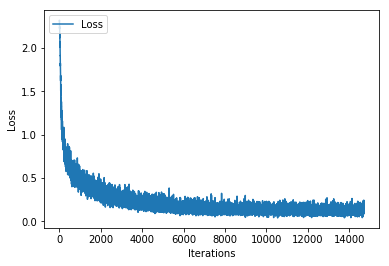

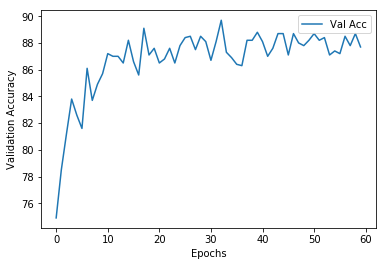

In [0]:
setSeeds(2)
input_size = 32 * 32 * 3
layer_config= [512, 256]
num_classes = 10
num_epochs = 60
batch_size = 600
learning_rate = 1e-4
learning_rate_decay = 0.9
reg=0.001

vgg, accVGG = trainAndTest(VggModel, num_classes, fine_tune=False, pretrained=True, nameOfModel='vggModel')

## 4.5 Training the Alex Net Model

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 90077826.42it/s]


AlexModel(
  (input): Interpolate()
  (model): Sequential(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5)
      (1): Linear(in_features=9216, out_features=512, bias=True)
      (

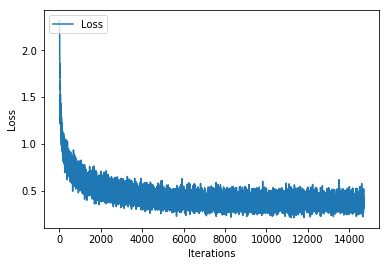

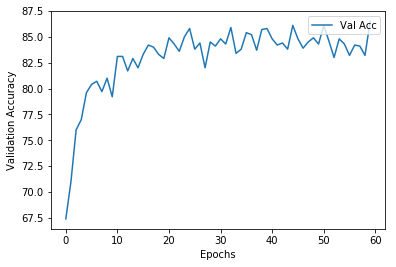

In [0]:
setSeeds(2)
input_size = 32 * 32 * 3
layer_config= [512, 256]
num_classes = 10
num_epochs = 60
batch_size = 600
learning_rate = 1e-4
learning_rate_decay = 0.9
reg=0.001

alex, accALEX = trainAndTest(AlexModel, num_classes, fine_tune=False, pretrained=True, nameOfModel='alexModel')

## 4.6 Training the GoogLeNet Model

GoogLeNetModel(
  (input): Interpolate()
  (model): Sequential(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (2): BasicConv2d(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): BasicConv2d(
        (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (5): Inception(
        (branch1): BasicConv2d(
          (conv): Conv2d(192, 64, kerne

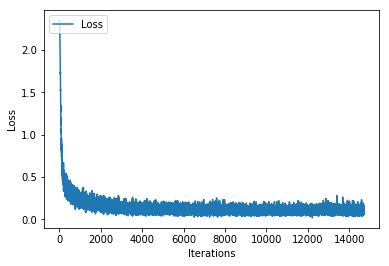

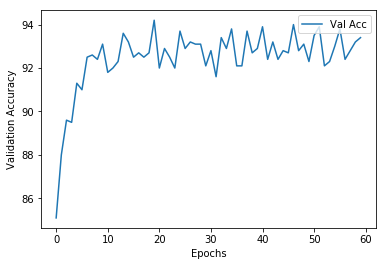

In [0]:
setSeeds(2)
input_size = 32 * 32 * 3
num_classes = 10

num_epochs = 60
learning_rate = 1e-4
learning_rate_decay = 0.85
reg=0.001

googlenet, accGOOGLE = trainAndTest(GoogLeNetModel , num_classes, fine_tune=False, pretrained=True, nameOfModel='googleNetModel')

## 4.7 Training the ResNet Model

ResNetModel(
  (input): Interpolate()
  (model): Sequential(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

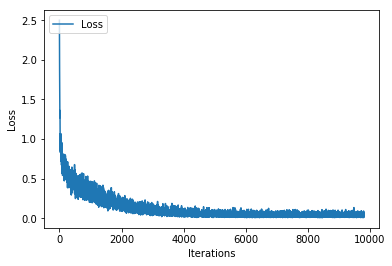

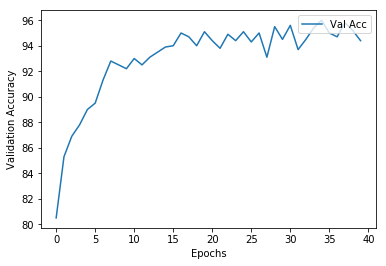

In [0]:
setSeeds(2)
input_size = 32 * 32 * 3
num_classes = 10

num_epochs = 40
learning_rate = 0.5e-3
learning_rate_decay = 0.8
reg=0.001

resnet, accRES = trainAndTest(ResNetModel , num_classes, fine_tune=False, pretrained=True, nameOfModel='resnetModel')

# 5. Testing the trained models

In [0]:
def loadModelAndTest(modelClass, modelName, fine_tune, pretrained):
  
    model= modelClass(num_classes, fine_tune, pretrained)
    model.load_state_dict(torch.load(path+'TransferLearning_models/'+ modelName +'.ckpt'))
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        allPredLabels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            allPredLabels.append(predicted)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        print('Accuracy of the best network on the {} test images: {} %'.format(total, acc))
        
    allPredLabels = [i.tolist() for i in allPredLabels]
    y_pred = [item for sublist in allPredLabels for item in sublist]
        
    return model, acc, y_pred

## 5.1 Testing

In [0]:
setSeeds(2)
input_size = 32 * 32 * 3
layer_config= [512, 256]
num_classes = 10
num_epochs = 60
batch_size = 600
learning_rate = 1e-4
learning_rate_decay = 0.9
reg=0.001

In [91]:
vgg, accVGG, y_pred_vgg = loadModelAndTest(VggModel, 'vggModel', fine_tune=False, pretrained=True)



Accuracy of the best network on the 10000 test images: 91.06 %


In [92]:
alex, accALEX, y_pred_alex = loadModelAndTest(AlexModel, 'alexModel', fine_tune=False, pretrained=True)


Accuracy of the best network on the 10000 test images: 90.05 %


In [93]:
googlenet, accGOOGLE, y_pred_google = loadModelAndTest(GoogLeNetModel, 'googleNetModel', fine_tune=False, pretrained=True)



Accuracy of the best network on the 10000 test images: 95.78 %


In [94]:
resnet, accRES, y_pred_resnet = loadModelAndTest(ResNetModel, 'resnetModel', fine_tune=False, pretrained=True)


Accuracy of the best network on the 10000 test images: 96.42 %


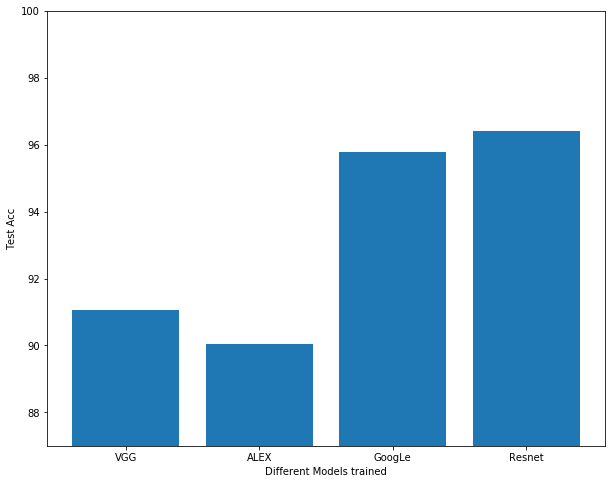

In [95]:
height = [accVGG, accALEX, accGOOGLE, accRES]
bars = ('VGG', 'ALEX', 'GoogLe', 'Resnet')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.xlabel('Different Models trained')
plt.ylabel('Test Acc')
plt.ylim([87,100])
 
# Show graphic
plt.show()

## 5.2 Visualizing some filters

In [0]:
def VisualizeFilter(mod, superTitle):
    
    tensor = torch.ones(mod.model.features[0].weight.data.size())
    tensor = mod.model.features[0].weight.clone().detach().requires_grad_(False)
    tensor = tensor.permute(0, 2, 3, 1) 
    tensor = tensor.cpu().data.numpy()
    
    t_max = np.amax(tensor)
    t_min = np.amin(tensor)

    tensor = (tensor - t_min) / (t_max - t_min) 

    num_cols = 16
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    fig.set_facecolor("black")

    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i],)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    
    fig.suptitle(superTitle, color='white')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

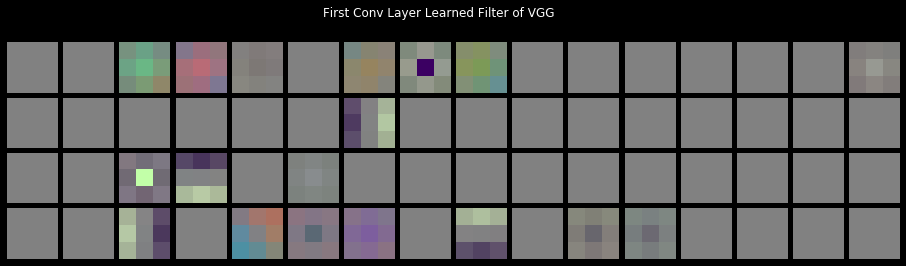

In [97]:
VisualizeFilter(vgg, 'First Conv Layer Learned Filter of VGG')


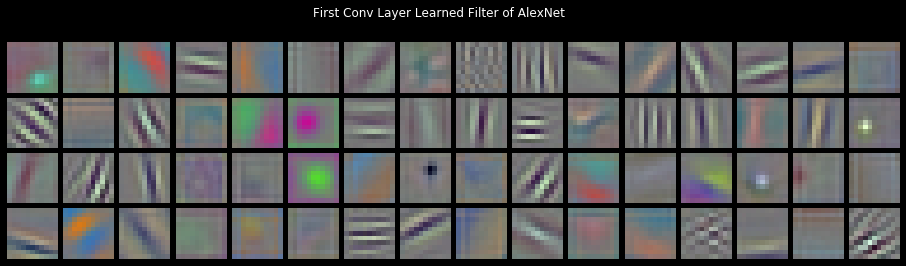

In [98]:
VisualizeFilter(alex, 'First Conv Layer Learned Filter of AlexNet')


## 5.3 Displaying Classification Results

In [0]:
def getLabels(dataset):
    labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i][1])
    return labels
    
def display_classification_results(y_test, y_pred, labelNames,title="Accuracy Heatmap",show_report=True):
    
    print("Test accuracy: %.2f%%"%(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    
    if show_report:
        print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))
    
    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:\n",conf_mat)
    
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    ax = sns.heatmap(conf_mat, xticklabels=labelNames, yticklabels=labelNames, annot=True, fmt="d", cbar_kws={'label': 'Num Correct'})
    ax.set(title=title, xlabel="Actual Classes", ylabel="Predicted Classes")

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [101]:
metaDataPath = path+'dataset/cifar-10-batches-py/batches.meta'
metaData = unpickle(metaDataPath)
label_names_bin = 'label_names'.encode('utf-8')
labelNames = metaData[label_names_bin]
labelNames = [x.decode() for x in labelNames]
labelNames

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [0]:
y_test = testLabels = getLabels(test_dataset)

Test accuracy: 91.06%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      1000
           1       0.95      0.96      0.96      1000
           2       0.88      0.91      0.89      1000
           3       0.85      0.77      0.81      1000
           4       0.88      0.91      0.90      1000
           5       0.86      0.83      0.84      1000
           6       0.92      0.94      0.93      1000
           7       0.94      0.94      0.94      1000
           8       0.96      0.95      0.96      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:
 [[941   5  19   1   4   0   1   2  17  10]
 [  5 964   0   0   0   0   1   0   5  25]
 [  9   0 911   9  25  12  21  10   2   1]
 [  7   2  30 773  34  95  36  10   3  10]
 [  

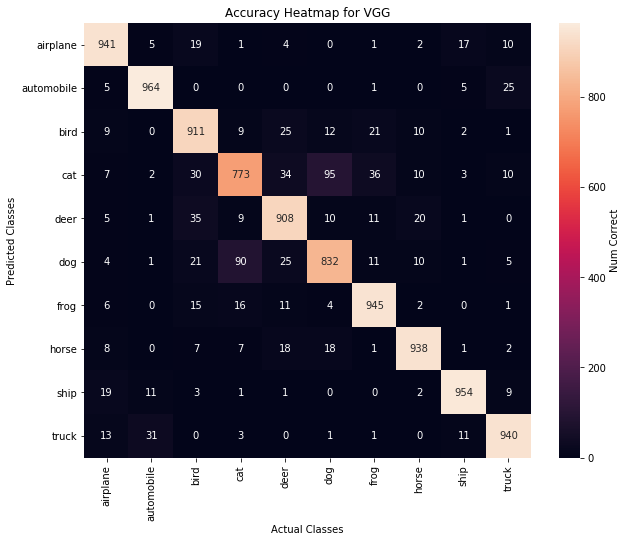

In [103]:
display_classification_results(y_test, y_pred_vgg,labelNames ,title="Accuracy Heatmap for VGG",show_report=True)

Test accuracy: 90.05%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1000
           1       0.93      0.95      0.94      1000
           2       0.88      0.88      0.88      1000
           3       0.85      0.77      0.81      1000
           4       0.85      0.92      0.88      1000
           5       0.89      0.82      0.85      1000
           6       0.91      0.95      0.93      1000
           7       0.92      0.92      0.92      1000
           8       0.95      0.93      0.94      1000
           9       0.94      0.93      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion Matrix:
 [[932   7  16   4   5   1   0   5  22   8]
 [  7 955   0   1   1   0   1   0   4  31]
 [ 20   2 880  20  35  12  20   9   1   1]
 [ 12   3  37 773  43  67  37  14   9   5]
 [  

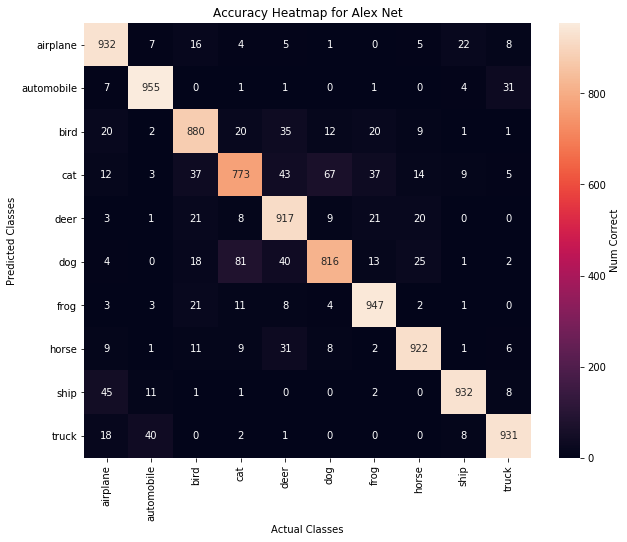

In [104]:
display_classification_results(y_test, y_pred_alex,labelNames , title="Accuracy Heatmap for Alex Net",show_report=True)

Test accuracy: 95.78%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1000
           1       0.98      0.98      0.98      1000
           2       0.96      0.96      0.96      1000
           3       0.92      0.89      0.90      1000
           4       0.95      0.97      0.96      1000
           5       0.93      0.92      0.92      1000
           6       0.96      0.99      0.97      1000
           7       0.98      0.96      0.97      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
 [[973   1   6   2   2   0   1   0  12   3]
 [  2 978   0   0   0   0   0   0   2  18]
 [  5   0 957  14   9   8   4   1   2   0]
 [  4   1  15 888  12  52  18   4   3   3]
 [  

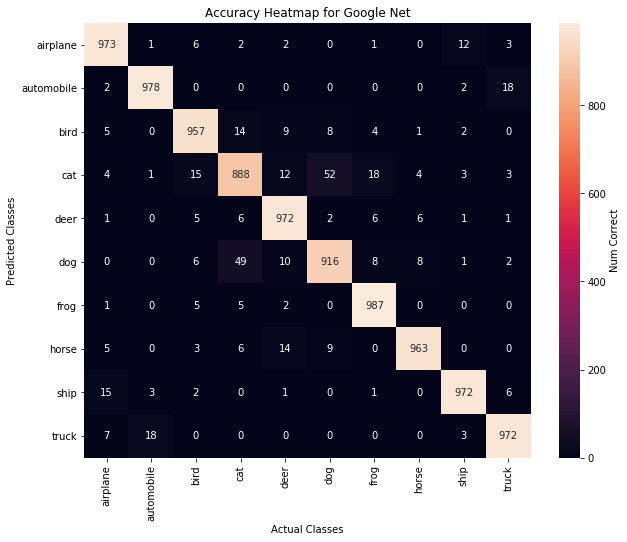

In [105]:
display_classification_results(y_test, y_pred_google, labelNames, title="Accuracy Heatmap for Google Net",show_report=True)

Test accuracy: 96.42%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.97      0.99      0.98      1000
           2       0.95      0.97      0.96      1000
           3       0.92      0.91      0.92      1000
           4       0.97      0.98      0.97      1000
           5       0.95      0.92      0.93      1000
           6       0.98      0.98      0.98      1000
           7       0.99      0.98      0.98      1000
           8       0.98      0.97      0.97      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
 [[981   1   6   0   2   0   1   0   7   2]
 [  2 986   1   0   1   0   0   0   1   9]
 [  5   0 974   8   5   3   3   0   2   0]
 [  1   1  17 912  10  40  11   2   4   2]
 [  

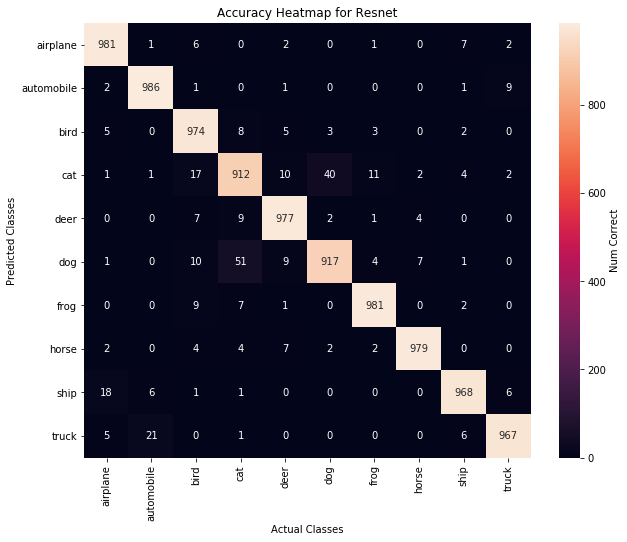

In [106]:
display_classification_results(y_test, y_pred_resnet,labelNames,title="Accuracy Heatmap for Resnet",show_report=True)

# 6. Visualizing incorrect Predictions by the best model ie. Resnet 30 

In [0]:
def visualizePreds(y_test, y_pred, test_dataset, labelNames, visualizeCorrect=False):
    
    correct = np.array(y_test) == np.array(y_pred)
    pos = []
    posPredLabel = []
    posTrueLabel = []
    
    if visualizeCorrect:
        while len(pos) <= 10:
            i = random.randint(0, len(y_pred))
            if y_test[i] == y_pred[i]:

                
                pos.append(i)
                posPredLabel.append(y_pred[i])
                posTrueLabel.append(y_test[i])

    else:
        while len(pos) <= 10:
            i = random.randint(0, len(y_pred))
            if y_test[i] != y_pred[i]:
                pos.append(i)
                posPredLabel.append(y_pred[i])
                posTrueLabel.append(y_test[i])
                
    
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,16))

    i = 0
    for row in ax:
        for col in row:
            img = test_dataset[pos[i]][0]
#             img = np.rollaxis(np.array(img),0,3)
            minVal = float(img.min())
            maxVal = float(img.max())
            col.imshow(toimage(img.data.numpy(), minVal, maxVal))
            col.set_title('True Label: '+str(y_test[pos[i]])+' '+labelNames[y_test[pos[i]]]+'\n Pred Label: '+str(y_pred[pos[i]])+' '+labelNames[y_pred[pos[i]]])
            col.set_xticks([])
            col.set_yticks([])
            i += 1
            
    plt.tight_layout()
    plt.show()

In [0]:
def toimage(imgArray, minVal, maxVal):
    
    minVal = -1 * minVal    
    imgArray = np.rollaxis(np.array(imgArray),0,3)
    if len(imgArray.shape) == 3:

        processed = []
        for channel in range(3):
            channelImg = imgArray[:,:, channel]

            for i in range(imgArray.shape[0]):
                for j in range(imgArray.shape[1]):
                    channelImg[i,j] = (channelImg[i,j] + minVal) / (minVal+maxVal) 

            processed.append(channelImg)

        img = np.rollaxis(np.array(processed),0,3)
    else:
        img = imgArray[:,:]

        for i in range(imgArray.shape[0]):
            for j in range(imgArray.shape[1]):
                img[i,j] = (img[i,j]+1)/2
            
       
    return img

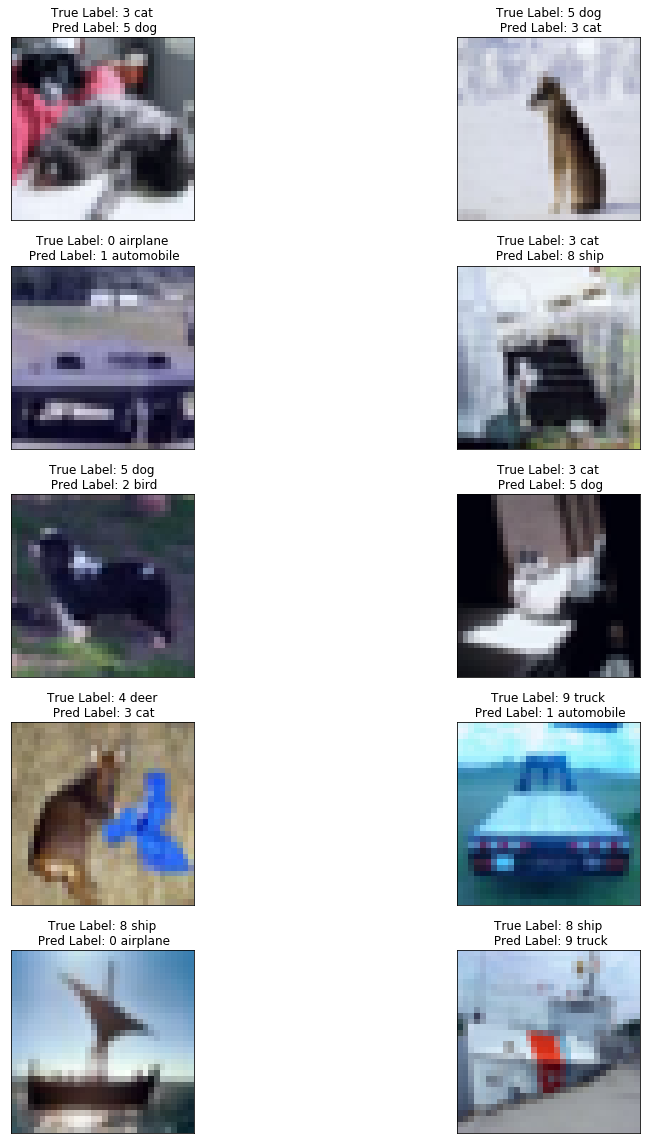

In [147]:
# Visualizing incorrect predictions
visualizePreds(y_test, y_pred_resnet,test_dataset, labelNames)